# **<span id="DataPrep" style="color:#3b51e3;">Data Preparation</span>**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd 
from datetime import datetime, timedelta # calculate the duration between two dates and times
import gc                                # garbage collector
import time
import multiprocessing as mp             # supports spawning processes using an API similar to the threading module
from multiprocessing import Pool         # offers a convenient means of parallelizing the execution of a function across multiple input values, 
                                         # distributing the input data across processes (data parallelism)
from functools import partial            # higher order function which takes a function as input (like map and filter)

import glob
from tqdm import tqdm
from collections import Counter
import sklearn
from sklearn import metrics
import recmetrics
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# read dataset 
## memory reduction in importing dtype={'article_id': 'int32'}
transactions = pd.read_csv('/content/drive/MyDrive/Project_Data/transactions_train.csv',dtype={'article_id': 'int32'})

customers = pd.read_csv('/content/drive/MyDrive/Project_Data/customers.csv')

articles = pd.read_csv('/content/drive/MyDrive/Project_Data/articles.csv',dtype={'article_id': 'int32'})


In [ ]:
# memory reduction 
transactions['t_dat'] = transactions['t_dat'].map(lambda x: datetime.strptime(x, '%Y-%m-%d')) #  creates a datetime object from the given string
transactions['customer_id'] = transactions['customer_id'].apply(lambda x: int(x[-16:],16) ).astype('int64') # Taking 16 character out of 63
customers['customer_id'] = customers['customer_id'].apply(lambda x: int(x[-16:],16) ).astype('int64')

# Splitting
val_start_date = '2020-09-16'
train_df = transactions.query(f"t_dat < '{val_start_date}'").reset_index(drop=True) # query() - Returns DataFrame resulting from the provided query expression
valid_df = transactions.query(f"t_dat >= '{val_start_date}'").reset_index(drop=True)

# Sorting
train_df = train_df.sort_values(["customer_id", "t_dat"], ascending=False)
valid_df = valid_df.sort_values(["customer_id", "t_dat"], ascending=False)

_ = gc.collect()

In [ ]:
train_df.head()

,t_dat,customer_id,article_id,price,sales_channel_id
20029657,2019-12-11,9223370729206611574,781758003,0.022864,2
20029658,2019-12-11,9223370729206611574,679525012,0.045746,2
8866196,2019-04-17,9223357421094039679,565379022,0.008458,2
8866197,2019-04-17,9223357421094039679,565379022,0.008458,2
8866198,2019-04-17,9223357421094039679,565379022,0.008458,2


In [ ]:
valid_df.head()

,t_dat,customer_id,article_id,price,sales_channel_id
74930,2020-09-18,9223141695752178477,914441003,0.033881,1
164339,2020-09-20,9223099843213569889,903924002,0.022017,2
133499,2020-09-19,9222310594107555341,884319001,0.022017,1
133500,2020-09-19,9222310594107555341,884319003,0.022017,1
144852,2020-09-20,9221813808370389952,869331006,0.030492,2


In [ ]:
valid_df = valid_df.sort_values(['customer_id', 't_dat'], ascending = [True, True]) 
valid_cust = valid_df.groupby('customer_id')['article_id'].apply(list).reset_index()
valid_cust['valid_true'] = valid_cust['article_id'].map(lambda x: '0'+' 0'.join(str(x)[1:-1].split(', ')))
del valid_df, valid_cust['article_id']
_ = gc.collect()

In [ ]:
valid_cust.tail()

,customer_id,valid_true
68979,9221607025486275188,0751994003 0699755081 0699755071
68980,9221813808370389952,0869331006 0562245099 0865929002
68981,9222310594107555341,0884319001 0884319003
68982,9223099843213569889,0903924002
68983,9223141695752178477,0914441003


## Defining funtions

    Computes the average precision at k.
    This function computes the average prescision at k between two lists of
    items.
    Parameters
    ----------
    actual : list
             A list of elements that are to be predicted (order doesn't matter)
    predicted : list
                A list of predicted elements (order does matter)
    k : int, optional
        The maximum number of predicted elements
    Returns
    -------
    score : double
            The average precision at k over the input lists

In [ ]:
def apk(actual, predicted, k=10):

    if len(predicted)>k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0

    for i,p in enumerate(predicted):   # enumerate() lets you get the index of an element while iterating over a list
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0)

    if not actual:
        return 0.0

    return score / min(len(actual), k)


    Computes the mean average precision at k.
    This function computes the mean average prescision at k between two lists
    of lists of items.
    Parameters
    ----------
    actual : list
             A list of lists of elements that are to be predicted 
             (order doesn't matter in the lists)
    predicted : list
                A list of lists of predicted elements
                (order matters in the lists)
    k : int, optional
        The maximum number of predicted elements
    Returns
    -------
    score : double
            The mean average precision at k over the input lists

In [ ]:

def mapk(actual, predicted, k=12):

    return np.mean([apk(a,p,k) for a,p in zip(actual, predicted) if a]) # CHANGES: ignore null actual (variable=a)

## Model 1 
Popularity based recommendaton system

In [ ]:
eval1 = customers.copy() 

top_12_items = train_df.groupby('article_id')['customer_id'].nunique().sort_values(ascending=False).head(12).index.tolist()
top_12_items = ['0' + str(item) for item in top_12_items]
eval1['prediction'] =  ' '.join(top_12_items)
eval1 = valid_cust.merge(eval1, on ='customer_id', how ='left')


In [ ]:
eval1.tail()

,customer_id,valid_true,FN,Active,club_member_status,fashion_news_frequency,age,postal_code,prediction
68979,9221607025486275188,0751994003 0699755081 0699755071,NaN,NaN,ACTIVE,NONE,44.0,c717d9a4432c328b9d108bf8d106649ab0ac8e1ff36f51...,0706016001 0372860001 0706016002 0610776002 07...
68980,9221813808370389952,0869331006 0562245099 0865929002,1.0,1.0,ACTIVE,Regularly,30.0,5ea9ac782453dc46850bc5b5656ee98ee3f82c526af50d...,0706016001 0372860001 0706016002 0610776002 07...
68981,9222310594107555341,0884319001 0884319003,1.0,1.0,ACTIVE,Regularly,32.0,16aec9971c1e5827bffc7b5fde81e4272d6f7cc8fb0382...,0706016001 0372860001 0706016002 0610776002 07...
68982,9223099843213569889,0903924002,1.0,1.0,ACTIVE,Regularly,29.0,bc7815826fa3022931067f286b9c9be997f7c49972af35...,0706016001 0372860001 0706016002 0610776002 07...
68983,9223141695752178477,0914441003,1.0,1.0,ACTIVE,Regularly,19.0,61ecf92a5307cd7295d20a3e45dec32d888bcbe0d82a44...,0706016001 0372860001 0706016002 0610776002 07...


In [ ]:
mapk(
    eval1['valid_true'].map(lambda x: x.split()), 
    eval1['prediction'].map(lambda x: x.split()), 
    k=12
)

0.0028084825086935154

In [ ]:
score_card = pd.DataFrame(columns=['Model_No','Model_Name','valid_score'])

# print the score card
score_card

,Model_No,Model_Name,valid_score


In [ ]:
model_1 = pd.Series({
                     'Model_No': 'Model 1',
                     'Model_Name': "Popularity Based Recommendation",
                     'valid_score': mapk(
    eval1['valid_true'].map(lambda x: x.split()), 
    eval1['prediction'].map(lambda x: x.split()), 
    k=12)})

                

# append our result table using append()
# ignore_index=True: does not use the index labels
# python can only append a Series if ignore_index=True or if the Series has a name
score_card = score_card.append(model_1, ignore_index=True)

# print the result table
score_card

,Model_No,Model_Name,valid_score
0,Model 1,Popularity Based Recommendation,0.002808


In [ ]:
del top_12_items
_ = gc.collect()

## Model 2

Model used content based recommendation that uses the most frequent recently bought items as predicted values.

In [ ]:
eval2 = customers.copy() 

most_frequent_articles = list(train_df.loc[train_df.t_dat==train_df.t_dat.max()].article_id.value_counts()[0:12].index)
art_list = []
for art in most_frequent_articles:
    art = "0"+str(art)
    art_list.append(art)
art_str = " ".join(art_list)

def padding_articles(x):
    if x:
        xl = x.split()
        x = []
        for xi in xl:
            x.append("0"+xi)
        dimm_x = len(x)
        if dimm_x < 12:
            x.extend(art_list[:12-dimm_x])
        return(" ".join(x))
    

eval2 = train_df.groupby(["customer_id"])["article_id"].agg(lambda x: str(x.values[0:12])[1:-1]).reset_index()
eval2["prediction"] = eval2["article_id"].apply(lambda x: padding_articles(x))
eval2 = valid_cust.merge(eval2, on ='customer_id', how ='left')

eval2['prediction'] = eval2['prediction'].astype(str)

In [ ]:
eval2.tail()

,customer_id,valid_true,article_id,prediction
68979,9221607025486275188,0751994003 0699755081 0699755071,816586002 452898020 864928002 783418003 720125...,0816586002 0452898020 0864928002 0783418003 07...
68980,9221813808370389952,0869331006 0562245099 0865929002,749699002 849519004 756209004 749699002 870611...,0749699002 0849519004 0756209004 0749699002 08...
68981,9222310594107555341,0884319001 0884319003,863595005 863595002 904416002 863646003 919599...,0863595005 0863595002 0904416002 0863646003 09...
68982,9223099843213569889,0903924002,903773002 717727014 827968004 757909004 849487...,0903773002 0717727014 0827968004 0757909004 08...
68983,9223141695752178477,0914441003,608776024 399223034 777070001 632784001 573716...,0608776024 0399223034 0777070001 0632784001 05...


In [ ]:
mapk(
    eval2['valid_true'].map(lambda x: x.split()), 
    eval2['prediction'].map(lambda x: x.split()), 
    k=12
)

0.021186250896550587

In [ ]:
model_2 = pd.Series({
                     'Model_No': 'Model 2',
                     'Model_Name': "Content Based Recommendation",
                     'valid_score':mapk(
    eval2['valid_true'].map(lambda x: x.split()), 
    eval2['prediction'].map(lambda x: x.split()), 
    k=12)
                   })

score_card = score_card.append(model_2, ignore_index=True)

score_card

,Model_No,Model_Name,valid_score
0,Model 1,Popularity Based Recommendation,0.002808
1,Model 2,Content Based Recommendation,0.021186


In [ ]:
del most_frequent_articles, art_list
_ = gc.collect()

## Model 3

In [ ]:
eval3 = customers[['customer_id']]

transactions_3w = train_df[train_df['t_dat'] >= pd.to_datetime('2020-08-24')].copy()
transactions_2w = train_df[train_df['t_dat'] >= pd.to_datetime('2020-08-31')].copy()
transactions_1w = train_df[train_df['t_dat'] >= pd.to_datetime('2020-09-07')].copy()

purchase_dict_3w = {}

for i,x in enumerate(zip(transactions_3w['customer_id'], transactions_3w['article_id'])):
    cust_id, art_id = x
    if cust_id not in purchase_dict_3w:
        purchase_dict_3w[cust_id] = {}
    
    if art_id not in purchase_dict_3w[cust_id]:
        purchase_dict_3w[cust_id][art_id] = 0
    
    purchase_dict_3w[cust_id][art_id] += 1
    
dummy_list_3w = list((transactions_3w['article_id'].value_counts()).index)[:12]
dummy_list_3w = ['0' + str(item) for item in dummy_list_3w]


purchase_dict_2w = {}

for i,x in enumerate(zip(transactions_2w['customer_id'], transactions_2w['article_id'])):
    cust_id, art_id = x
    if cust_id not in purchase_dict_2w:
        purchase_dict_2w[cust_id] = {}
    
    if art_id not in purchase_dict_2w[cust_id]:
        purchase_dict_2w[cust_id][art_id] = 0
    
    purchase_dict_2w[cust_id][art_id] += 1
    

dummy_list_2w = list((transactions_2w['article_id'].value_counts()).index)[:12]
dummy_list_2w = ['0' + str(item) for item in dummy_list_2w]


purchase_dict_1w = {}

for i,x in enumerate(zip(transactions_1w['customer_id'], transactions_1w['article_id'])):
    cust_id, art_id = x
    if cust_id not in purchase_dict_1w:
        purchase_dict_1w[cust_id] = {}
    
    if art_id not in purchase_dict_1w[cust_id]:
        purchase_dict_1w[cust_id][art_id] = 0
    
    purchase_dict_1w[cust_id][art_id] += 1
    
dummy_list_1w = list((transactions_1w['article_id'].value_counts()).index)[:12]
dummy_list_1w = ['0' + str(item) for item in dummy_list_1w]


prediction_list = []

dummy_list = list((transactions_1w['article_id'].value_counts()).index)[:12]
dummy_list = ['0' + str(item) for item in dummy_list]
dummy_pred = ' '.join(dummy_list)

for i, cust_id in enumerate(eval3['customer_id'].values.reshape((-1,))):
    if cust_id in purchase_dict_1w:
        l = sorted((purchase_dict_1w[cust_id]).items(), key=lambda x: x[1], reverse=True)
        l = ['0' + str(y[0]) for y in l]
        if len(l)>12:
            s = ' '.join(l[:12])
        else:
            s = ' '.join(l+dummy_list_1w[:(12-len(l))])
    elif cust_id in purchase_dict_2w:
        l = sorted((purchase_dict_2w[cust_id]).items(), key=lambda x: x[1], reverse=True)
        l = ['0' + str(y[0]) for y in l]
        if len(l)>12:
            s = ' '.join(l[:12])
        else:
            s = ' '.join(l+dummy_list_2w[:(12-len(l))])
    elif cust_id in purchase_dict_3w:
        l = sorted((purchase_dict_3w[cust_id]).items(), key=lambda x: x[1], reverse=True)
        l = ['0' + str(y[0]) for y in l]
        if len(l)>12:
            s = ' '.join(l[:12])
        else:
            s = ' '.join(l+dummy_list_3w[:(12-len(l))])
    else:
        s = dummy_pred
    prediction_list.append(s)

eval3['prediction'] = prediction_list
eval3 = valid_cust.merge(eval3, on ='customer_id', how ='left')
eval3['prediction'] = eval3['prediction'].astype(str)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
eval3.tail()

,customer_id,valid_true,prediction
68979,9221607025486275188,0751994003 0699755081 0699755071,0816586002 0751471001 0915526001 0751471043 09...
68980,9221813808370389952,0869331006 0562245099 0865929002,0749699002 0849519004 0751471001 0915526001 07...
68981,9222310594107555341,0884319001 0884319003,0909370001 0918522001 0865799006 0448509014 07...
68982,9223099843213569889,0903924002,0909370001 0918522001 0865799006 0448509014 07...
68983,9223141695752178477,0914441003,0909370001 0918522001 0865799006 0448509014 07...


In [ ]:
mapk(
    eval3['valid_true'].map(lambda x: x.split()), 
    eval3['prediction'].map(lambda x: x.split()), 
    k=12
)

0.023769364797432333

In [ ]:
model_3 = pd.Series({
                     'Model_No': "Model 3",
                     'Model_Name': "Content Based with Time Decay Concept",
                     'valid_score':mapk(
    eval3['valid_true'].map(lambda x: x.split()), 
    eval3['prediction'].map(lambda x: x.split()), 
    k=12)
                   })

score_card = score_card.append(model_3, ignore_index=True)

score_card

,Model_No,Model_Name,valid_score
0,Model 1,Popularity Based Recommendation,0.002808
1,Model 2,Content Based Recommendation,0.021186
2,Model 3,Content Based with Time Decay Concept,0.023769


In [ ]:
del prediction_list, transactions_3w, transactions_2w, transactions_1w
del purchase_dict_3w, purchase_dict_2w, purchase_dict_1w, dummy_list_3w, dummy_list_2w,dummy_list_1w
del dummy_list, dummy_pred

_ = gc.collect()

## Model 4
### Collaborative Filtering: User-user

-- For a given user (u), we will search for similar users. Let's say, the 10 most similar users to u. This is u's neighborhood.


--We search for the most popular items in this neighborhood of users similar to u, I


--We check the items that are popular in the group of users similar to u, that u hasn't purchased yet.


--We recommend those items to u


Now, we need to operationalize two things here:


--What does it mean that 2 users are similar?


--What does it mean that an item is popular in a group of users?


For the similarity among users, we will just compare their purchases. The overlap of their purchased items is the similarity of the users. With this idea, we want to capture users with similar consumption patterns.


For the popularity of items in a group, there are more simple and more complex definitions. We can just take the number of purchases a given product has in a group and rank all the possible products with that metric. Or we can consider the similarity to the original user u and weight the purchases depending on who was purchasing. That way, purchases of users that are more similar to u will have a stronger impact on the overall ranking of products.

In [ ]:
dfu = customers.copy()
dfi = articles.copy()

ALL_USERS = dfu['customer_id'].unique().tolist()
ALL_ITEMS = dfi['article_id'].unique().tolist()

user_to_customer_map = {user_id: customer_id for user_id, customer_id in enumerate(ALL_USERS)}
customer_to_user_map = {customer_id: user_id for user_id, customer_id in enumerate(ALL_USERS)}

item_to_article_map = {item_id: article_id for item_id, article_id in enumerate(ALL_ITEMS)}
article_to_item_map = {article_id: item_id for item_id, article_id in enumerate(ALL_ITEMS)}

del dfu, dfi

df = train_df.copy() 

df['user_id'] = df['customer_id'].map(customer_to_user_map)
df['item_id'] = df['article_id'].map(article_to_item_map)



In [ ]:
# Configuration parameters

N_SIMILAR_USERS = 20
MINIMUM_PURCHASES = 10
START_DATE = '2020-08-31' # '2020-09-16'
DROP_PURCHASED_ITEMS = False
DROP_USER_FROM_HIS_NEIGHBORHOOD = False
TEST_RUN = False
TEST_SIZE = 1000

In [ ]:
#  Flatten a list of lists

def flatten(l):
    return [item for sublist in l for item in sublist]

    Compare lists of purchased product for two given users
    v1 stands for the "vector representation for user 1", which is a list of the purchases of u1
    
    Returns:
        A value between 0 and 1 (similarity)

In [ ]:
def compare_vectors(v1, v2):
    intersection = len(set(v1) & set(v2))
    denominator = np.sqrt(len(v1) * len(v2))
    return intersection / denominator
    

    Get the N_SIMILAR_USERS most similar users to the given one with their similarity score
    Arguments:
        u: the user_id, 
        v:  the "vector" representation of the user (list of item_id)
        dfh : the "history of transaccions" dataframe
        
    Returns:
        tuple of lists ([similar user_id], [similarity scores])

In [ ]:
def get_similar_users(u, v, dfh):
    similar_users = dfh.apply(lambda v_other: compare_vectors(v, v_other)).sort_values(ascending=False).head(N_SIMILAR_USERS + 1)
    
    if DROP_USER_FROM_HIS_NEIGHBORHOOD:
        similar_users = similar_users[similar_users.index != u]
        
    return similar_users.index.tolist(), similar_users.tolist()

     Get the recommend items for a given users
    
    It will:
        1) Get similar users for the given user
        2) Obtain all the items those users purchased
        3) Rank them using the similarity scores of the user that purchased them
        4) Return the 12 best ranked
    
    Arguments:
        u: the user_id, 
        v:  the "vector" representation of the user (list of item_id)
        dfh : the "history of transaccions" dataframe
        
    Returns:
        list of item_id of lenght at most 12

In [ ]:
def get_items(u, v, dfh):
    global i, n
    
    users, scores = get_similar_users(u, v, dfh)
    df_nn = pd.DataFrame({'user': users, 'score': scores})
    df_nn['items'] = df_nn.apply(lambda row: dfh.loc[row.user], axis=1)
    df_nn['weighted_items'] = df_nn.apply(lambda row: [(item, row.score) for item in row['items']], axis=1)

    recs = pd.DataFrame(flatten(df_nn['weighted_items'].tolist()), columns=['item', 'score']).groupby('item')['score'].sum().sort_values(ascending=False)
    if DROP_PURCHASED_ITEMS:
        recs = recs[~recs.index.isin(v)]
    # Keep the first 12 and get the item_ids
    i +=1
    if i % 200 == 0:
        pid = mp.current_process().pid
        print(f"[PID {pid:>2d}] Finished {i:3d} / {n:5d} - {i/n*100:3.0f}%")
    return recs.head(12).index.tolist()

    Call get_item for a list of user_ids
    
    Arguments:
        user_ids: list of user_id, 
        dfh: the "history of transaccions" dataframe
        
    Returns:
        pd.Series with index user_id and list of item_id (recommendations) as value
  

In [ ]:
def get_items_chunk(user_ids: np.array, dfh: pd.DataFrame):
    global i, n
    i = 0
    
    n = len(user_ids)
    pid = mp.current_process().pid
    print(f"[PID {pid:>2d}] Started working with {n:5d} users")
    
    df_user_vectors = pd.DataFrame(dfh.loc[user_ids]).reset_index()
    df_user_vectors['recs'] = df_user_vectors.apply(lambda row: get_items(row.user_id, row.item_id, dfh), axis=1)
    return df_user_vectors.set_index('user_id')['recs']


    Obtained recommendation for the users using transaccion dfh in a parallelized manner
    
    Call get_items_chunk in a "smart" multiprocessing fashion
    
    Arguments:
        users: list of user_id
        dfh: the "history of transaccions" dataframe
    
    Returns:
        pd.DataFrame with index user_id and list of item_id (recommendations) as value
    
  

In [ ]:
def get_recommendations(users: list, dfh: pd.DataFrame):

    time_start = time.time()
    
    # Split into approximately evenly sized chunks
    # We will send just one batch to each CPU 
    user_chunks = np.array_split(users, mp.cpu_count())
    
    f = partial(get_items_chunk, dfh=dfh)
    with Pool(mp.cpu_count()) as p:
        res = p.map(f, user_chunks)
    
    df_rec = pd.DataFrame(pd.concat(res))

    elapsed = (time.time() - time_start) / 60
    print(f"Finished get_recommendations({len(users)}). It took {elapsed:5.2f} mins")
    return df_rec

    Entry point for the UUCF model. 
    
    Receive the original transactions_train.csv and a start_date and gets UUCF recommendations
    
    The model will not cover the full list of users, but just a subset of them.
    
    It will provide recommendations for users with at least MINIMUM_PURCHASES after start_date.
    It might return less than 12 recs per user.
    
    An ad-hoc function for filling these gaps should be used downstream.
    (See fill functionality right below)
    
    
    Arguments:
        df: The raw dataframe from transactions_train.csv
        start_date: a date
        
    Returns:
        a submission-like pd.DataFrame with columns [customer_id, prediction]
        'prediction' is a list and not a string though
    
    

In [ ]:
def uucf(df, start_date=START_DATE):

    df_small = df[df['t_dat'] > start_date]
    print(f"Kept data from {start_date} on. Total rows: {len(df_small)}")
    
    # H stands for "Transaction history"
    # dfh is a series of user_id => list of item_id (the list of purchases in order)
    dfh = df_small.groupby("user_id")['item_id'].apply(lambda items: list(set(items)))
    dfh = dfh[dfh.str.len() >= MINIMUM_PURCHASES]
    if TEST_RUN:
        print("WARNING: TEST_RUN is True. It will be a toy execution.")
        dfh = dfh.head(TEST_SIZE)
    
    users = dfh.index.tolist()
    n_users = len(users)
    print(f"Total users in the time frame with at least {MINIMUM_PURCHASES}: {n_users}")
    
    df_rec = get_recommendations(users, dfh)
    df_rec['customer_id'] = df_rec.index.map(user_to_customer_map)
    df_rec['prediction'] = df_rec['recs'].map(lambda l: [item_to_article_map[i] for i in l])
    
    # Submission ready dataframe
    df_rec.reset_index(drop=True)[['customer_id', 'prediction']]
    return df_rec 

df_recs = uucf(df)

df_fill = eval3.copy()[['customer_id', 'prediction']]

Kept data from 2020-08-31 on. Total rows: 557958
Total users in the time frame with at least 10: 7476
[PID 2828] Started working with  3738 users
[PID 2829] Started working with  3738 users
[PID 2828] Finished 200 /  3738 -   5%
[PID 2829] Finished 200 /  3738 -   5%
[PID 2828] Finished 400 /  3738 -  11%
[PID 2829] Finished 400 /  3738 -  11%
[PID 2829] Finished 600 /  3738 -  16%
[PID 2828] Finished 600 /  3738 -  16%
[PID 2828] Finished 800 /  3738 -  21%
[PID 2829] Finished 800 /  3738 -  21%
[PID 2828] Finished 1000 /  3738 -  27%
[PID 2829] Finished 1000 /  3738 -  27%
[PID 2828] Finished 1200 /  3738 -  32%
[PID 2829] Finished 1200 /  3738 -  32%
[PID 2828] Finished 1400 /  3738 -  37%
[PID 2829] Finished 1400 /  3738 -  37%
[PID 2828] Finished 1600 /  3738 -  43%
[PID 2829] Finished 1600 /  3738 -  43%
[PID 2828] Finished 1800 /  3738 -  48%
[PID 2829] Finished 1800 /  3738 -  48%
[PID 2828] Finished 2000 /  3738 -  54%
[PID 2829] Finished 2000 /  3738 -  54%
[PID 2828] Finishe

In [ ]:
def uucf(df, start_date=START_DATE):

    df_small = df[df['t_dat'] > start_date]
    print(f"Kept data from {start_date} on. Total rows: {len(df_small)}")
    
    # H stands for "Transaction history"
    # dfh is a series of user_id => list of item_id (the list of purchases in order)
    dfh = df_small.groupby("user_id")['item_id'].apply(lambda items: list(set(items)))
    dfh = dfh[dfh.str.len() >= MINIMUM_PURCHASES]
    if TEST_RUN:
        print("WARNING: TEST_RUN is True. It will be a toy execution.")
        dfh = dfh.head(TEST_SIZE)
    
    users = dfh.index.tolist()
    n_users = len(users)
    print(f"Total users in the time frame with at least {MINIMUM_PURCHASES}: {n_users}")
    
    df_rec = get_recommendations(users, dfh)
    df_rec['customer_id'] = df_rec.index.map(user_to_customer_map)
    df_rec['prediction'] = df_rec['recs'].map(lambda l: [item_to_article_map[i] for i in l])
    # Submission ready dataframe
    df_rec.reset_index(drop=True)[['customer_id', 'prediction']]
    return df_rec 

In [ ]:
df_recs = uucf(df)

df_fill = eval3.copy()[['customer_id', 'prediction']]

Kept data from 2020-08-31 on. Total rows: 557958
Total users in the time frame with at least 10: 7476
[PID 2919] Started working with  3738 users
[PID 2920] Started working with  3738 users
[PID 2919] Finished 200 /  3738 -   5%
[PID 2920] Finished 200 /  3738 -   5%
[PID 2919] Finished 400 /  3738 -  11%
[PID 2920] Finished 400 /  3738 -  11%
[PID 2919] Finished 600 /  3738 -  16%
[PID 2920] Finished 600 /  3738 -  16%
[PID 2919] Finished 800 /  3738 -  21%
[PID 2920] Finished 800 /  3738 -  21%
[PID 2919] Finished 1000 /  3738 -  27%
[PID 2920] Finished 1000 /  3738 -  27%
[PID 2919] Finished 1200 /  3738 -  32%
[PID 2920] Finished 1200 /  3738 -  32%
[PID 2919] Finished 1400 /  3738 -  37%
[PID 2920] Finished 1400 /  3738 -  37%
[PID 2919] Finished 1600 /  3738 -  43%
[PID 2920] Finished 1600 /  3738 -  43%
[PID 2919] Finished 1800 /  3738 -  48%
[PID 2920] Finished 1800 /  3738 -  48%
[PID 2919] Finished 2000 /  3738 -  54%
[PID 2920] Finished 2000 /  3738 -  54%
[PID 2919] Finishe

In [ ]:
## Remove duplicates of a given sequence keeping order

def drop_duplicates(seq):
    seen = set()
    seen_add = seen.add
    return [x for x in seq if not (x in seen or seen_add(x))]

In [ ]:
def fill_row(row):
    uucf = row['prediction_uucf']
    fill = row['prediction_fill'].split()
    new_list = drop_duplicates(uucf + fill)[:12]
    return ' '.join(new_list)

In [ ]:
def fill(df_recs, df_fill):
    df_recs['len'] = df_recs['prediction'].str.len()
    df_recs = pd.merge(df_fill, df_recs, how='left', on='customer_id', suffixes=('_fill', '_uucf'))
        # No recs from UUCF at all: use the fallback model 
    df_recs.loc[df_recs['prediction_uucf'].isnull(), 'prediction'] = df_recs['prediction_fill']


    # Full UUCF recommendation
    mask = df_recs['prediction_uucf'].notnull() & (df_recs['len'] == 12)
    df_recs.loc[mask, 'prediction'] = df_recs['prediction_uucf']


    # Fill with another model. Not enough recs from UUCF
    fill_mask = df_recs['prediction_uucf'].notnull() & (df_recs['len'] < 12)
    df_recs.loc[fill_mask, 'prediction'] = df_recs[fill_mask].apply(fill_row, axis=1)
    return df_recs.drop(['prediction_uucf', 'prediction_fill', 'len', 'recs'], axis=1)

In [ ]:
eval4 = fill(df_recs, df_fill)
eval4 = valid_cust.merge(eval4, on ='customer_id', how ='left')
eval4['prediction'] = eval4['prediction'].astype(str)

In [ ]:
eval4.tail() 

,customer_id,valid_true,prediction
68979,9221607025486275188,0751994003 0699755081 0699755071,0816586002 0751471001 0915526001 0751471043 09...
68980,9221813808370389952,0869331006 0562245099 0865929002,0749699002 0849519004 0751471001 0915526001 07...
68981,9222310594107555341,0884319001 0884319003,0909370001 0918522001 0865799006 0448509014 07...
68982,9223099843213569889,0903924002,0909370001 0918522001 0865799006 0448509014 07...
68983,9223141695752178477,0914441003,0909370001 0918522001 0865799006 0448509014 07...


In [ ]:
mapk(
    eval4['valid_true'].map(lambda x: x.split()), 
    eval4['prediction'].map(lambda x: x.split()), 
    k=12
)

0.022463243041822765

In [ ]:
model_4 = pd.Series({
                     'Model_No': "Model 4",
                     'Model_Name': "Collaborative Based Filtering (User-User)",
                     'valid_score':mapk(
    eval4['valid_true'].map(lambda x: x.split()), 
    eval4['prediction'].map(lambda x: x.split()), 
    k=12)
                   })

score_card = score_card.append(model_4, ignore_index=True)

score_card

,Model_No,Model_Name,valid_score
0,Model 1,Popularity Based Recommendation,0.002808
1,Model 2,Content Based Recommendation,0.021186
2,Model 3,Content Based with Time Decay Concept,0.023769
3,Model 4,Collaborative Based Filtering (User-User),0.022463


In [ ]:
del eval4, df_recs, df_fill
_ = gc.collect()

# Model 5 (SVD MODEL)

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Project_Data/transactions_train.csv', dtype={'article_id':str})
data["t_dat"] = pd.to_datetime(data["t_dat"])
data.head()

,t_dat,customer_id,article_id,price,sales_channel_id
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0663713001,0.050831,2
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0541518023,0.030492,2
2,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,0505221004,0.015237,2
3,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,0685687003,0.016932,2
4,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,0685687004,0.016932,2


In [ ]:
print("All Transactions Date Range: {} to {}".format(data['t_dat'].min(), data['t_dat'].max()))

data["t_dat"] = pd.to_datetime(data["t_dat"])
train1 = data.loc[(data["t_dat"] >= datetime(2020,9,8)) & (data['t_dat'] < datetime(2020,9,16))]
train2 = data.loc[(data["t_dat"] >= datetime(2020,9,1)) & (data['t_dat'] < datetime(2020,9,8))]
train3 = data.loc[(data["t_dat"] >= datetime(2020,8,23)) & (data['t_dat'] < datetime(2020,9,1))]
train4 = data.loc[(data["t_dat"] >= datetime(2020,8,15)) & (data['t_dat'] < datetime(2020,8,23))]

val = data.loc[data["t_dat"] >= datetime(2020,9,16)]

All Transactions Date Range: 2018-09-20 00:00:00 to 2020-09-22 00:00:00


In [ ]:
# List of all purchases per user (has repetitions)
positive_items_per_user1 = train1.groupby(['customer_id'])['article_id'].apply(list)
positive_items_per_user2 = train2.groupby(['customer_id'])['article_id'].apply(list)
positive_items_per_user3 = train3.groupby(['customer_id'])['article_id'].apply(list)
positive_items_per_user4 = train4.groupby(['customer_id'])['article_id'].apply(list)

There can be multiple ways to convert the implicit data to explicit. But all ways have the same fundamental idea. We'll treat the purchase of an unpopular item to be of high explicit feedback and that of a popular item to be of low explicit feedback. Also, if an user buys a lot of items, that can weigh down the importance of one single item.

Some ideas:

    user-item purchase count weighed down by time decaying popularity of the item as introduced in last model
    user-item purchase count weighed down by the product of total purchase count of the item and total purchase count of the user.

Note: No idea is the absolute perfect. As you will combine different heuristic approaches with the SVD you'll realize different conversion techniques are favourable for different heuristics approaches.

In [ ]:
train = pd.concat([train1, train2, train3, train4], axis=0)

#time decay popularity of each article
train['pop_factor'] = train['t_dat'].apply(lambda x: 1/(datetime(2020,9,16) - x).days**2)
popular_items_group = train.groupby(['article_id'])['pop_factor'].sum()

# purchase count of each article
items_total_count = train.groupby(['article_id'])['article_id'].count()
# purchase count of each user
users_total_count = train.groupby(['customer_id'])['customer_id'].count()


train['feedback'] = 1
train = train.groupby(['customer_id', 'article_id']).sum().reset_index()
train['feedback'] = train.apply(lambda row: row['feedback']/popular_items_group[row['article_id']], axis=1)

train['feedback'] = train['feedback'].apply(lambda x: 5.0 if x>5.0 else x)
train.drop(['price', 'sales_channel_id'], axis=1, inplace=True)

# shuffling
train = train.sample(frac=1).reset_index(drop=True)
train['feedback'].describe()

count    1.044811e+06
mean     8.252942e-01
std      1.455205e+00
min      5.373625e-03
25%      6.460413e-02
50%      1.771086e-01
75%      6.486035e-01
max      5.000000e+00
Name: feedback, dtype: float64

In [ ]:
# Basic time decaying popularity to combine it with the SVD.

train_pop = data.loc[(data["t_dat"] >= datetime(2020,9,1)) & (data['t_dat'] < datetime(2020,9,16))]
train_pop['pop_factor'] = train_pop['t_dat'].apply(lambda x: 1/(datetime(2020,9,16) - x).days)
popular_items_group = train_pop.groupby(['article_id'])['pop_factor'].sum()

_, popular_items = zip(*sorted(zip(popular_items_group, popular_items_group.keys()))[::-1])

train_pop['pop_factor'].describe()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


count    557958.000000
mean          0.200478
std           0.207752
min           0.066667
25%           0.083333
50%           0.125000
75%           0.200000
max           1.000000
Name: pop_factor, dtype: float64



Below part is a cool new addition which gives a small bump. Did not add it to the validation part but it has the same effect there too. It predicts the most frequent next item bought by an user after a particular item.


In [ ]:
def get_most_freq_next_item(user_group):
    next_items = {}
    for user in tqdm(user_group.keys()):
        items = user_group[user]
        for i,item in enumerate(items[:-1]):
            if item not in next_items:
                next_items[item] = []
            if item != items[i+1]:
                next_items[item].append(items[i+1])

    pred_next = {}
    for item in next_items:
        if len(next_items[item]) >= 5:
            most_common = Counter(next_items[item]).most_common()
            ratio = most_common[0][1]/len(next_items[item])
            if ratio >= 0.1:
                pred_next[item] = most_common[0][0]
            
    return pred_next

user_group = train.groupby(['customer_id'])['article_id'].apply(list)
pred_next = get_most_freq_next_item(user_group)

100%|██████████| 254618/254618 [00:01<00:00, 159520.60it/s]


In [ ]:
!pip install git+https://github.com/mayukh18/reco

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/mayukh18/reco to /tmp/pip-req-build-itl4wpux
  Running command git clone -q https://github.com/mayukh18/reco /tmp/pip-req-build-itl4wpux


In [ ]:
# SVD Training

from reco.recommender import FunkSVD
from reco.metrics import rmse

# k = number of dimensions of the latent embedding. formatizer dict takes in names of the columns
# for user, item and values/feedback/ratings respectively.

svd = FunkSVD(k=8, learning_rate=0.008, regularizer = .01, iterations = 100, method = 'stochastic', bias=True)
svd.fit(X=train, formatizer={'user':'customer_id', 'item':'article_id', 'value':'feedback'},verbose=True)

Epoch 0: Error: 0.6738641567108314
Epoch 1: Error: 0.47520048078406957
Epoch 2: Error: 0.4065792350410468
Epoch 3: Error: 0.36594160887683247
Epoch 4: Error: 0.33797110022491395
Epoch 5: Error: 0.31685904115338387
Epoch 6: Error: 0.2998705954312253
Epoch 7: Error: 0.2855881338665681
Epoch 8: Error: 0.273218305365306
Epoch 9: Error: 0.262258022588333
Epoch 10: Error: 0.2523690760044968
Epoch 11: Error: 0.24331053863863455
Epoch 12: Error: 0.23493989583108013
Epoch 13: Error: 0.22714758559359405
Epoch 14: Error: 0.2198511865663092
Epoch 15: Error: 0.2129945927993364
Epoch 16: Error: 0.20653301936698595
Epoch 17: Error: 0.20043598468548615
Epoch 18: Error: 0.1946817818753313
Epoch 19: Error: 0.18924716059179517
Epoch 20: Error: 0.18410982617374477
Epoch 21: Error: 0.1792507052642103
Epoch 22: Error: 0.17465275561706362
Epoch 23: Error: 0.1702988803898957
Epoch 24: Error: 0.1661748570716088
Epoch 25: Error: 0.16226590897954216
Epoch 26: Error: 0.15855653059562763
Epoch 27: Error: 0.1550347


Validation 

This is mostly based on this notebook where I have used same pipeline. Will use SVD for re-ranking. Will read all the data anew and train a new model on our new train set with new date ranges for submission. This will align us with the aforementioned notebook.


In [ ]:
positive_items_val = val.groupby(['customer_id'])['article_id'].apply(list)
val_users = positive_items_val.keys()
val_items = []

for i,user in tqdm(enumerate(val_users)):
    val_items.append(positive_items_val[user])
    
print("Total users in validation:", len(val_users))

68984it [00:00, 207531.11it/s]

Total users in validation: 68984


In [ ]:
# Now, prediction WITH the SVD reranking!

from collections import Counter
outputs = []
cnt = 0

popular_items = list(popular_items)
userindexes = {svd.users[i]:i for i in range(len(svd.users))}

for user in tqdm(val_users):
    user_output = []
    if user in positive_items_per_user1.keys():
        most_common_items_of_user = {k:v for k, v in Counter(positive_items_per_user1[user]).most_common()}
        user_index = userindexes[user]
        new_order = {}
        for k in list(most_common_items_of_user.keys())[:20]:
            try:
                itemindex = svd.items.index(k)
                pred_value = np.dot(svd.userfeatures[user_index], svd.itemfeatures[itemindex].T) + svd.item_bias[0, itemindex]
            except:
                pred_value = most_common_items_of_user[k]
            new_order[k] = pred_value
        user_output += [k for k, v in sorted(new_order.items(), key=lambda item: item[1])][:12]
        
    if user in positive_items_per_user2.keys():
        most_common_items_of_user = {k:v for k, v in Counter(positive_items_per_user2[user]).most_common()}
        user_index = userindexes[user]
        new_order = {}
        for k in list(most_common_items_of_user.keys())[:20]:
            try:
                itemindex = svd.items.index(k)
                pred_value = np.dot(svd.userfeatures[user_index], svd.itemfeatures[itemindex].T) + svd.item_bias[0, itemindex]
            except:
                pred_value = most_common_items_of_user[k]
            new_order[k] = pred_value
        user_output += [k for k, v in sorted(new_order.items(), key=lambda item: item[1])][:12]
        
    if user in positive_items_per_user3.keys():
        most_common_items_of_user = {k:v for k, v in Counter(positive_items_per_user3[user]).most_common()}
        user_index = userindexes[user]
        new_order = {}
        for k in list(most_common_items_of_user.keys())[:20]:
            try:
                itemindex = svd.items.index(k)
                pred_value = np.dot(svd.userfeatures[user_index], svd.itemfeatures[itemindex].T) + svd.item_bias[0, itemindex]
            except:
                pred_value = most_common_items_of_user[k]
            new_order[k] = pred_value
        user_output += [k for k, v in sorted(new_order.items(), key=lambda item: item[1])][:12]
        
    if user in positive_items_per_user4.keys():
        most_common_items_of_user = {k:v for k, v in Counter(positive_items_per_user4[user]).most_common()}
        user_index = userindexes[user]
        new_order = {}
        for k in list(most_common_items_of_user.keys())[:20]:
            try:
                itemindex = svd.items.index(k)
                pred_value = np.dot(svd.userfeatures[user_index], svd.itemfeatures[itemindex].T) + svd.item_bias[0, itemindex]
            except:
                pred_value = most_common_items_of_user[k]
            new_order[k] = pred_value
        user_output += [k for k, v in sorted(new_order.items(), key=lambda item: item[1])][:12]
        
    user_output += [pred_next[item] for item in user_output if item in pred_next and pred_next[item] not in user_output]      
    
    user_output += list(popular_items[:12 - len(user_output)])
    outputs.append(user_output)
    
print("mAP Score on Validation set:", mapk(val_items, outputs))

100%|██████████| 68984/68984 [01:41<00:00, 679.52it/s]


mAP Score on Validation set: 0.025375495918795326


In [ ]:
model_5 = pd.Series({
                     'Model_No': "Model 5",
                     'Model_Name': "Time Based Popularity with SVD Reranking",
                     'valid_score': mapk(val_items, outputs)
                   })

score_card = score_card.append(model_5, ignore_index=True)

score_card

,Model_No,Model_Name,valid_score
0,Model 1,Popularity Based Recommendation,0.002808
1,Model 2,Content Based Recommendation,0.021186
2,Model 3,Content Based with Time Decay Concept,0.023769
3,Model 4,Collaborative Based Filtering (User-User),0.022463
4,Model 5,Time Based Popularity with SVD Reranking,0.025375


# Model 6 (SVD Reranking)

In [ ]:
data = data.loc[data['sales_channel_id'] == 2]

In [ ]:
print("All Transactions Date Range: {} to {}".format(data['t_dat'].min(), data['t_dat'].max()))

data["t_dat"] = pd.to_datetime(data["t_dat"])
train1 = data.loc[(data["t_dat"] >= datetime(2020,9,8)) & (data['t_dat'] < datetime(2020,9,16))]
train2 = data.loc[(data["t_dat"] >= datetime(2020,9,1)) & (data['t_dat'] < datetime(2020,9,8))]
train3 = data.loc[(data["t_dat"] >= datetime(2020,8,23)) & (data['t_dat'] < datetime(2020,9,1))]
train4 = data.loc[(data["t_dat"] >= datetime(2020,8,15)) & (data['t_dat'] < datetime(2020,8,23))]

val = data.loc[data["t_dat"] >= datetime(2020,9,16)]

All Transactions Date Range: 2018-09-20 00:00:00 to 2020-09-22 00:00:00


In [ ]:
# List of all purchases per user (has repetitions)
positive_items_per_user1 = train1.groupby(['customer_id'])['article_id'].apply(list)
positive_items_per_user2 = train2.groupby(['customer_id'])['article_id'].apply(list)
positive_items_per_user3 = train3.groupby(['customer_id'])['article_id'].apply(list)
positive_items_per_user4 = train4.groupby(['customer_id'])['article_id'].apply(list)

In [ ]:
train = pd.concat([train1, train2, train3, train4], axis=0)

#time decay popularity of each article
train['pop_factor'] = train['t_dat'].apply(lambda x: 1/(datetime(2020,9,16) - x).days**2)
popular_items_group = train.groupby(['article_id'])['pop_factor'].sum()

# purchase count of each article
items_total_count = train.groupby(['article_id'])['article_id'].count()
# purchase count of each user
users_total_count = train.groupby(['customer_id'])['customer_id'].count()


train['feedback'] = 1
train = train.groupby(['customer_id', 'article_id']).sum().reset_index()
train['feedback'] = train.apply(lambda row: row['feedback']/popular_items_group[row['article_id']], axis=1)

train['feedback'] = train['feedback'].apply(lambda x: 5.0 if x>5.0 else x)
train.drop(['price', 'sales_channel_id'], axis=1, inplace=True)

# shuffling
train = train.sample(frac=1).reset_index(drop=True)
train['feedback'].describe()

count    669558.000000
mean          0.907346
std           1.530959
min           0.006190
25%           0.072147
50%           0.188461
75%           0.747018
max           5.000000
Name: feedback, dtype: float64

In [ ]:
# Basic time decaying popularity to combine it with the SVD.

train_pop = data.loc[(data["t_dat"] >= datetime(2020,9,1)) & (data['t_dat'] < datetime(2020,9,16))]
train_pop['pop_factor'] = train_pop['t_dat'].apply(lambda x: 1/(datetime(2020,9,16) - x).days)
popular_items_group = train_pop.groupby(['article_id'])['pop_factor'].sum()

_, popular_items = zip(*sorted(zip(popular_items_group, popular_items_group.keys()))[::-1])

train_pop['pop_factor'].describe()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


count    382056.000000
mean          0.207264
std           0.214756
min           0.066667
25%           0.083333
50%           0.125000
75%           0.250000
max           1.000000
Name: pop_factor, dtype: float64

In [ ]:
def get_most_freq_next_item(user_group):
    next_items = {}
    for user in tqdm(user_group.keys()):
        items = user_group[user]
        for i,item in enumerate(items[:-1]):
            if item not in next_items:
                next_items[item] = []
            if item != items[i+1]:
                next_items[item].append(items[i+1])

    pred_next = {}
    for item in next_items:
        if len(next_items[item]) >= 5:
            most_common = Counter(next_items[item]).most_common()
            ratio = most_common[0][1]/len(next_items[item])
            if ratio >= 0.1:
                pred_next[item] = most_common[0][0]
            
    return pred_next

user_group = train.groupby(['customer_id'])['article_id'].apply(list)
pred_next = get_most_freq_next_item(user_group)

100%|██████████| 154755/154755 [00:01<00:00, 153056.86it/s]


In [ ]:
# SVD Training

from reco.recommender import FunkSVD
from reco.metrics import rmse

# k = number of dimensions of the latent embedding. formatizer dict takes in names of the columns
# for user, item and values/feedback/ratings respectively.

svd = FunkSVD(k=8, learning_rate=0.008, regularizer = .01, iterations = 100, method = 'stochastic', bias=True)
svd.fit(X=train, formatizer={'user':'customer_id', 'item':'article_id', 'value':'feedback'},verbose=True)

Epoch 0: Error: 0.755639467251134
Epoch 1: Error: 0.5347172235796901
Epoch 2: Error: 0.457749016045045
Epoch 3: Error: 0.41147116141388074
Epoch 4: Error: 0.37911973350455047
Epoch 5: Error: 0.35460091794145154
Epoch 6: Error: 0.3349648202645837
Epoch 7: Error: 0.31857428028835094
Epoch 8: Error: 0.3044644669853296
Epoch 9: Error: 0.2920331363313275
Epoch 10: Error: 0.2808674319199968
Epoch 11: Error: 0.2706900978671295
Epoch 12: Error: 0.2613123549967702
Epoch 13: Error: 0.2526094608739245
Epoch 14: Error: 0.24448871033034925
Epoch 15: Error: 0.2368822437134206
Epoch 16: Error: 0.22975283416783637
Epoch 17: Error: 0.22305108404322452
Epoch 18: Error: 0.21674208034325637
Epoch 19: Error: 0.21080017222839176
Epoch 20: Error: 0.20520067679869725
Epoch 21: Error: 0.19992290417431924
Epoch 22: Error: 0.19495194677786884
Epoch 23: Error: 0.19026473574224734
Epoch 24: Error: 0.18584338359254904
Epoch 25: Error: 0.18167047318762886
Epoch 26: Error: 0.17773099122526637
Epoch 27: Error: 0.17400

In [ ]:
positive_items_val = val.groupby(['customer_id'])['article_id'].apply(list)
val_users = positive_items_val.keys()
val_items = []

for i,user in tqdm(enumerate(val_users)):
    val_items.append(positive_items_val[user])
    
print("Total users in validation:", len(val_users))

41529it [00:00, 211851.11it/s]

Total users in validation: 41529


In [ ]:
# Now, prediction WITH the SVD reranking!

from collections import Counter
outputs = []
cnt = 0

popular_items = list(popular_items)
userindexes = {svd.users[i]:i for i in range(len(svd.users))}

for user in tqdm(val_users):
    user_output = []
    if user in positive_items_per_user1.keys():
        most_common_items_of_user = {k:v for k, v in Counter(positive_items_per_user1[user]).most_common()}
        user_index = userindexes[user]
        new_order = {}
        for k in list(most_common_items_of_user.keys())[:20]:
            try:
                itemindex = svd.items.index(k)
                pred_value = np.dot(svd.userfeatures[user_index], svd.itemfeatures[itemindex].T) + svd.item_bias[0, itemindex]
            except:
                pred_value = most_common_items_of_user[k]
            new_order[k] = pred_value
        user_output += [k for k, v in sorted(new_order.items(), key=lambda item: item[1])][:12]
        
    if user in positive_items_per_user2.keys():
        most_common_items_of_user = {k:v for k, v in Counter(positive_items_per_user2[user]).most_common()}
        user_index = userindexes[user]
        new_order = {}
        for k in list(most_common_items_of_user.keys())[:20]:
            try:
                itemindex = svd.items.index(k)
                pred_value = np.dot(svd.userfeatures[user_index], svd.itemfeatures[itemindex].T) + svd.item_bias[0, itemindex]
            except:
                pred_value = most_common_items_of_user[k]
            new_order[k] = pred_value
        user_output += [k for k, v in sorted(new_order.items(), key=lambda item: item[1])][:12]
        
    if user in positive_items_per_user3.keys():
        most_common_items_of_user = {k:v for k, v in Counter(positive_items_per_user3[user]).most_common()}
        user_index = userindexes[user]
        new_order = {}
        for k in list(most_common_items_of_user.keys())[:20]:
            try:
                itemindex = svd.items.index(k)
                pred_value = np.dot(svd.userfeatures[user_index], svd.itemfeatures[itemindex].T) + svd.item_bias[0, itemindex]
            except:
                pred_value = most_common_items_of_user[k]
            new_order[k] = pred_value
        user_output += [k for k, v in sorted(new_order.items(), key=lambda item: item[1])][:12]
        
    if user in positive_items_per_user4.keys():
        most_common_items_of_user = {k:v for k, v in Counter(positive_items_per_user4[user]).most_common()}
        user_index = userindexes[user]
        new_order = {}
        for k in list(most_common_items_of_user.keys())[:20]:
            try:
                itemindex = svd.items.index(k)
                pred_value = np.dot(svd.userfeatures[user_index], svd.itemfeatures[itemindex].T) + svd.item_bias[0, itemindex]
            except:
                pred_value = most_common_items_of_user[k]
            new_order[k] = pred_value
        user_output += [k for k, v in sorted(new_order.items(), key=lambda item: item[1])][:12]
        
    user_output += [pred_next[item] for item in user_output if item in pred_next and pred_next[item] not in user_output]      
    
    user_output += list(popular_items[:12 - len(user_output)])
    outputs.append(user_output)
    
print("mAP Score on Validation set:", mapk(val_items, outputs))

100%|██████████| 41529/41529 [00:39<00:00, 1038.31it/s]


mAP Score on Validation set: 0.032006600314958604


In [ ]:
model_6 = pd.Series({
                     'Model_No': "Model 6",
                     'Model_Name': "SVD Reranking implemented with customer grouping",
                     'valid_score': mapk(val_items, outputs)
                   })

score_card = score_card.append(model_6, ignore_index=True)

score_card

,Model_No,Model_Name,valid_score
0,Model 1,Popularity Based Recommendation,0.002808
1,Model 2,Content Based Recommendation,0.021186
2,Model 3,Content Based with Time Decay Concept,0.023769
3,Model 4,Collaborative Based Filtering (User-User),0.022463
4,Model 5,Time Based Popularity with SVD Reranking,0.025375
5,Model 6,SVD Reranking implemented with customer grouping,0.032007


Text(0.5, 0, 'Model Name')

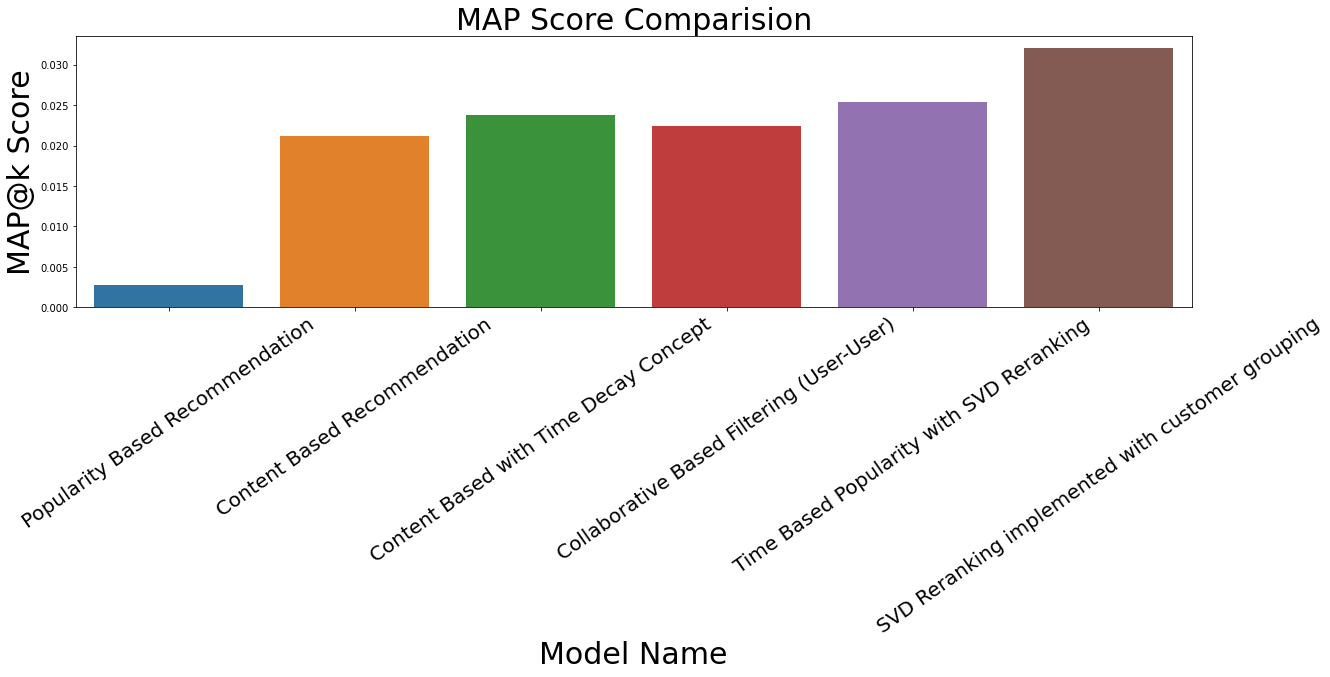

In [ ]:
plt.figure(figsize=(20,5))

sns.barplot(score_card['Model_Name'],score_card['valid_score'])
plt.xticks(rotation=35,fontsize=20 )
plt.title(f'MAP Score Comparision', fontsize=30)
plt.ylabel('MAP@k Score', fontsize=30)
plt.xlabel('Model Name', fontsize=30)